In [6]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
df = pd.read_csv('unbalanced_review_data.csv').dropna()

In [8]:
df = df[['star_rating', 'review_body']]

In [9]:
df.head()

,star_rating,review_body
0,5,This is the ultimate skillet. It is the best I...
1,5,Great product!!! for some people this works ...
2,5,This foam mattress is so comfortable. I had bo...
3,5,I wasn't expecting to much since the comforter...
4,4,"If there were a Bible for cats, this book woul..."


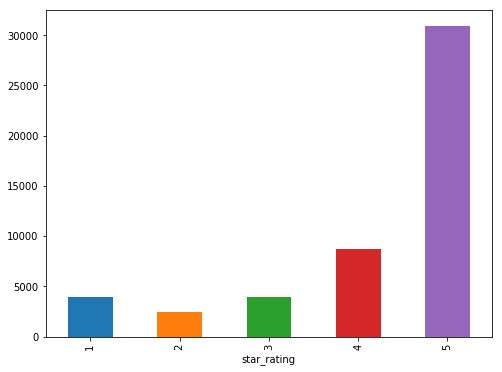

In [11]:
fig = plt.figure(figsize=(8,6))
df.groupby('star_rating').review_body.count().plot.bar()
plt.show()

In [12]:
df['review_body'][2]

"This foam mattress is so comfortable. I had bought the Twin XL for my son's college dorm, but when he came home on breaks he'd complain about his bed at home - so I bought him this one.  My daughter loves it so much she wants one.  My wife wants one for our Queen bed too."

In [13]:
corpus = df['review_body']

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=25, 
    stop_words='english', ngram_range=(1,2))
features = vectorizer.fit_transform(corpus).toarray()
labels = df['star_rating']

In [16]:
features.shape

(49996, 7987)

In [17]:
print(vectorizer.get_feature_names())

['00', '000', '10', '10 15', '10 days', '10 minutes', '10 year', '10 years', '100', '100 pages', '1000', '11', '11 year', '110', '12', '12 year', '120', '13', '14', '15', '15 minutes', '15 years', '150', '16', '17', '18', '180', '19', '1960', '1970', '1980', '1999', '1st', '20', '20 minutes', '20 years', '200', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '20th', '20th century', '21', '21st', '21st century', '22', '23', '24', '24 hours', '25', '250', '26', '27', '28', '29', '2nd', '30', '30 days', '30 minutes', '30 years', '300', '32', '33', '34', '34 34', '34 book', '34 br', '34 just', '34 like', '35', '36', '360', '38', '39', '3d', '3rd', '3x', '40', '400', '42', '45', '45 minutes', '48', '4s', '4th', '50', '500', '55', '5s', '5th', '60', '600', '62', '64', '65', '6th', '70', '70s', '72', '75', '80', '800', '80s', '90', '95', '98', '99', 'aa', 'aaa', 'abandoned', 'aber', 'abilities', 'ability', 'able',

In [18]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for star in range(1,6):
    features_chi2 = chi2(features, labels == star)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(vectorizer.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' star:".format(star))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# '1' star:
  . Most correlated unigrams:
. broke
. waste
  . Most correlated bigrams:
. don waste
. waste money
# '2' star:
  . Most correlated unigrams:
. great
. disappointed
  . Most correlated bigrams:
. poor quality
. did fit
# '3' star:
  . Most correlated unigrams:
. okay
. ok
  . Most correlated bigrams:
. bit disappointed
. just ok
# '4' star:
  . Most correlated unigrams:
. stars
. little
  . Most correlated bigrams:
. gave stars
. pretty good
# '5' star:
  . Most correlated unigrams:
. great
. love
  . Most correlated bigrams:
. highly recommend
. waste money


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['review_body'], df['star_rating'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [25]:
print(clf.predict(count_vect.transform(["This product is so bad, I hate it"])))

[5]


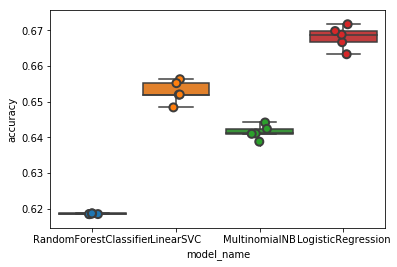

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [23]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.652773
LogisticRegression        0.668054
MultinomialNB             0.641491
RandomForestClassifier    0.618570
Name: accuracy, dtype: float64

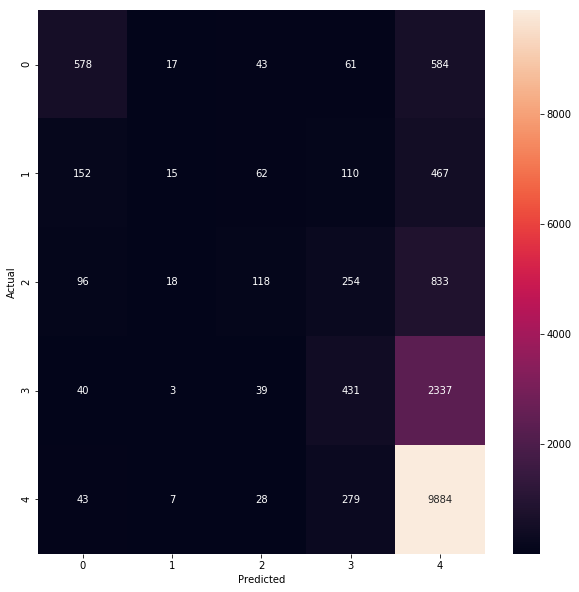

In [22]:
model = LogisticRegression()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [24]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.64      0.45      0.53      1283
          2       0.25      0.02      0.03       806
          3       0.41      0.09      0.15      1319
          4       0.38      0.15      0.22      2850
          5       0.70      0.97      0.81     10241

avg / total       0.59      0.67      0.60     16499

